The spatial organization of genes in the eukaryotic genome is influenced by a variety of factors such as genome size, transposable element activity, and nucleotide composition constraints.
There is a rich body of literature in evolutionary biology describing the relevant molecular mechanisms involved, of which Mike Lynch's [*Origins of Genome Architecture*](http://www.amazon.com/Origins-Genome-Architecture-Michael-Lynch/dp/0878934847) provides an excellent review.

What can we say about the spacing or distributions of genes we observe *now*, ignoring for a moment the mechanisms that resulted in this organization?
Most biologists are unlikely to contest the claim that genes are not randomly distributed throughout the genome, but this is a vague statement.
To provide clearer insight, we need to define what we mean by "random" and then observe how statistics of gene spacing differ for "random" gene spacings versus real (observed) gene spacings.

I don't address this fully here.
Rather, I have:

- sampled genomic regions from three species (paper wasp *Polistes dominula*; flour beetle *Tribolium castaneum*; western clawed frog *Xenopus tropicalis*)
- plotted the distribution of genes in each region
- randomly re-distributed the genes in each region
- re-plotted the distributions

The differences are clear and stark, but more work will be needed to provide biological insight.
Which statistics are relevant here (I've been working on this), and what can these statistics tell us about how genomes are organized?

## Graphics boilerplate code

As with anything involving matplotlib, we need to start with some boring boilerplate code.

In [2]:
%matplotlib inline
import gzip
import numpy
import re
import seaborn

seaborn.set_context({"figure.figsize": (12, 8)})

In [3]:
def plot_hist_rug(data, bins=30, xlim=None, ylim=None, title=None):
    """Boilerplate code for visualizations."""
    plot = seaborn.distplot(data, bins=bins, kde=False, rug=True)
    seaborn.plt.xlabel('Genomic position', fontsize=16)
    seaborn.plt.ylabel('Frequency', fontsize=16)
    if title:
        seaborn.plt.title(title, fontsize=18)
    if xlim is not None:
        _ = plot.set(xlim=(xlim[0], xlim[1]))
    if ylim is not None:
        _ = plot.set(ylim=(ylim[0], ylim[1]))

## Intervals

*In silico* we typically represent gene loci as intervals in a discrete number line.
My thinking about genome intervals has been heavily influenced by the [GFF3 specification](http://www.sequenceontology.org/resources/gff3.html), and so this simple implementation adopts the same conventions: a closed interval (ends inclusive), with counting starting at 1 (instead of 0).
Consider the following example.

```
           1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
           -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
                 [---A----]     [--------B--------]
```

In this example, we represent interval `A` as `[3, 6]`, with a length of 4 (calculated `end - start + 1 = 6 - 3 + 1 = 4`).
Interval `B` is represented as `[8, 14]` and has a length of `7`.

In [4]:
class Interval():
    """Simple implementation of a discrete closed interval."""

    def __init__(self, start, end, data=None):
        assert start <= end
        self.start = start
        self.end = end
        self.data = data

    def __len__(self):
        return self.end - self.start + 1

    def __repr__(self):
        return '[%d, %d]' % (self.start, self.end)

    def place(self, newstart):
        length = len(self)
        self.start = newstart
        self.end = newstart + length - 1

The data are stored in [GFF3 format](http://www.sequenceontology.org/resources/gff3.html), so now let's implement a parser to load features of interest into `Interval` objects.
We're interested in two types of entries in the GFF3 file.

- First, the `##sequence-region` pragma specifies the boundaries of our coordinate system (number line).
  GFF3 files are allowed to contain many such entries, but for our purposes we will assume our input has only one `##sequence-region` pragma.
- Second, features of type `locus` encode the intervals we're interested in, and specifically we want those with a `gene` attribute.
  Feature entries have 9 tab-separated values, with feature type stored in the third field and attributes stored in the ninth field.

In [5]:
def load_intervals(infile):
    """Load features of interest into Interval objects."""

    seqreg = None
    intervals = list()
    for line in infile:
        if seqreg is None:
            seqreg_pattern = '^##sequence-region\s+(\S+)\s+(\d+)\s+(\d+)'
            srmatch = re.search(seqreg_pattern, line)
            if srmatch:
                seqid = srmatch.group(1)
                start = int(srmatch.group(2))
                end = int(srmatch.group(3))
                length = end - start + 1
                seqreg = (length, start, end, seqid)

        values = line.rstrip().split('\t')
        if len(values) != 9:
            continue
        feature_type = values[2]
        attributes = values[8]
        if feature_type == 'locus' and 'gene=' in attributes:
            start = int(values[3])
            end = int(values[4])
            itvl = Interval(start, end, data=values)
            intervals.append(itvl)

    return seqreg, intervals

## Observed gene distribution

Now that we have implemented an interval and a simple parser, let's take a look at the distribution of genes in a couple of real data sets.

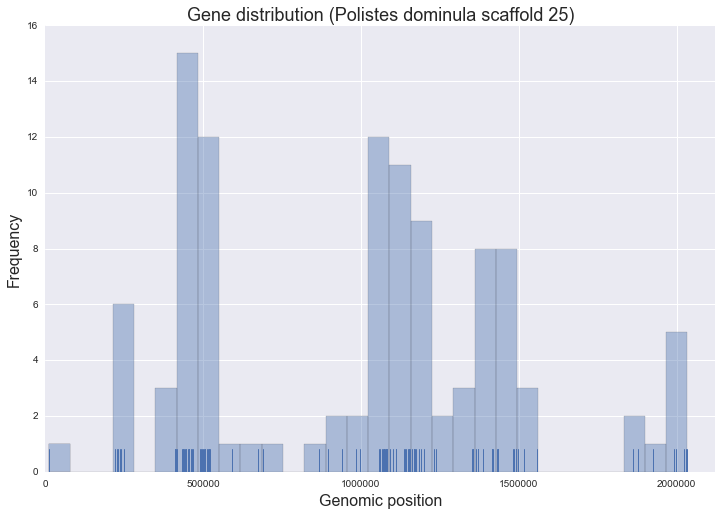

In [6]:
with gzip.open('pdom-scf25-iloci.gff3.gz', 'r') as infile:
    pd_seqreg, pd_intervals = load_intervals(infile)
starts = [x.start for x in pd_intervals]
plot_hist_rug(starts, title='Gene distribution (Polistes dominula scaffold 25)',
              xlim=(pd_seqreg[1], pd_seqreg[2]), ylim=(0, 16))

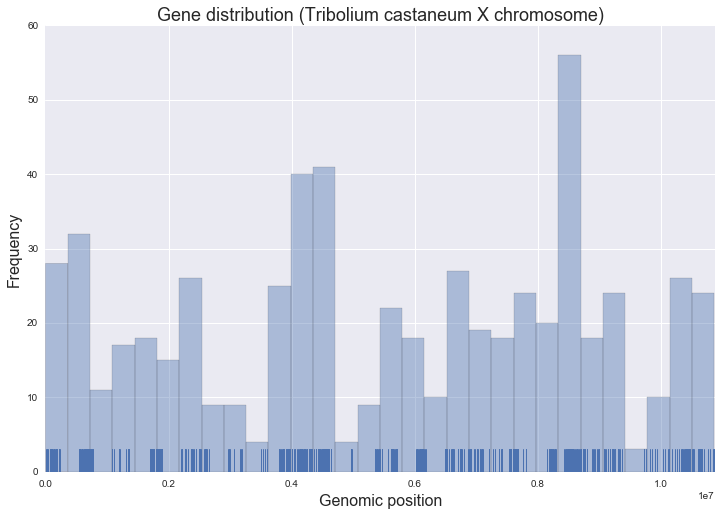

In [7]:
with gzip.open('NC_007416.2-loci.gff3.gz', 'r') as infile:
    tc_seqreg, tc_intervals = load_intervals(infile)
starts = [x.start for x in tc_intervals]
plot_hist_rug(starts, title='Gene distribution (Tribolium castaneum X chromosome)',
              xlim=(tc_seqreg[1], tc_seqreg[2]), ylim=(0, 60))

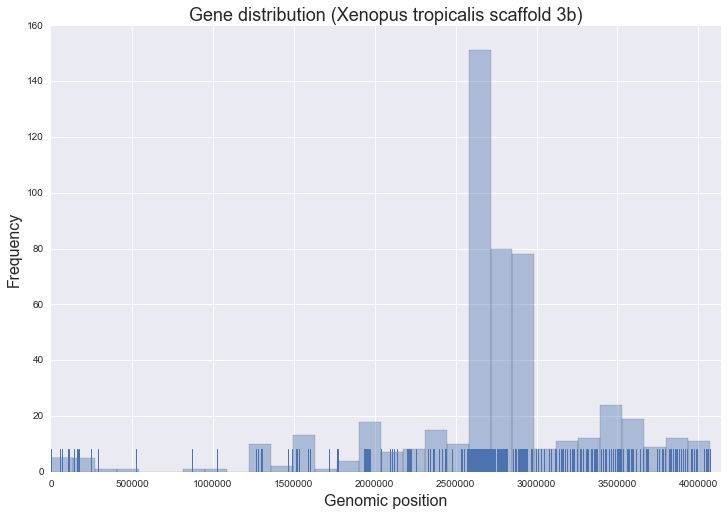

In [8]:
with gzip.open('NW_004668235.1-loci.gff3.gz', 'r') as infile:
    xt_seqreg, xt_intervals = load_intervals(infile)
starts = [x.start for x in xt_intervals]
plot_hist_rug(starts, title='Gene distribution (Xenopus tropicalis scaffold 3b)',
              xlim=(xt_seqreg[1], xt_seqreg[2]), ylim=(0, 160))

## Re-distribute genes

How do these plots change if we randomly re-distribute the genes?
See http://stackoverflow.com/q/33831442/459780.

In [9]:
def place_intervals(seqreg, intervals):
    """
    Re-place sub-intervals in a larger interval.

    Conceptually:
        0. Shrink sub-intervals to length 0 and shuffle
        1. For each sub-interval, select a new starting position,
           making sure it is not the starting position of any
           other sub-interval.
        2. Exand the sub-intervals back to their original size.
    """
    itvls = list(intervals)
    numpy.random.shuffle(itvls)

    n_open_slots = seqreg[0] - sum([len(x) for x in itvls])
    slots_taken = dict()
    collisions = 0
    for itvl in itvls:
        newslot = numpy.random.randint(1, n_open_slots)
        while newslot in slots_taken:
            collisions += 1
            newslot = numpy.random.randint(1, n_open_slots)
        slots_taken[newslot] = itvl

    slots = sorted(list(slots_taken))
    cumulative_offset = 0
    for slot in slots:
        itvl = slots_taken[slot]
        newstart = slot + cumulative_offset
        cumulative_offset += len(itvl)
        itvl.place(newstart)

    return itvls, collisions

# A bit of testing
numpy.random.seed(3333)
intervals = [ Interval(5, 15), Interval(33, 60), Interval(97, 98) ]
region = (100, 1, 100, 'reg')
place_intervals(region, intervals)

([[76, 86], [2, 29], [69, 70]], 0)

Collisions: 0


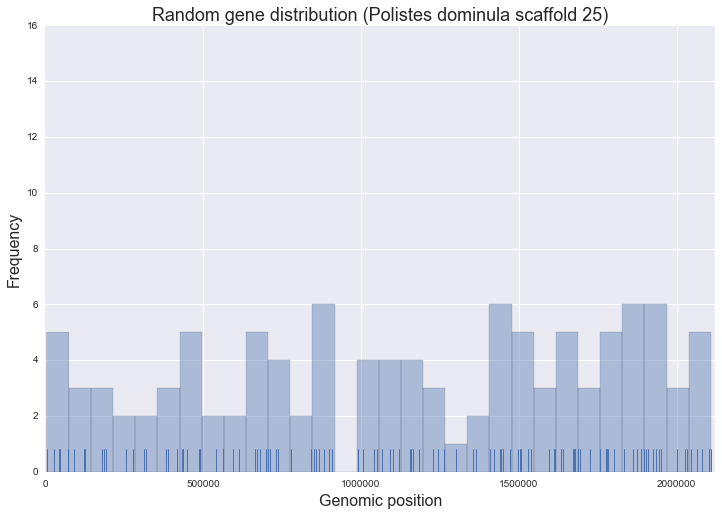

In [10]:
numpy.random.seed(3333)
pd_randintervals, collisions = place_intervals(pd_seqreg, pd_intervals)
starts = [x.start for x in pd_randintervals]
plot_hist_rug(starts, title='Random gene distribution (Polistes dominula scaffold 25)',
              xlim=(pd_seqreg[1], pd_seqreg[2]), ylim=(0, 16))
print 'Collisions: %d' % collisions

Collisions: 0


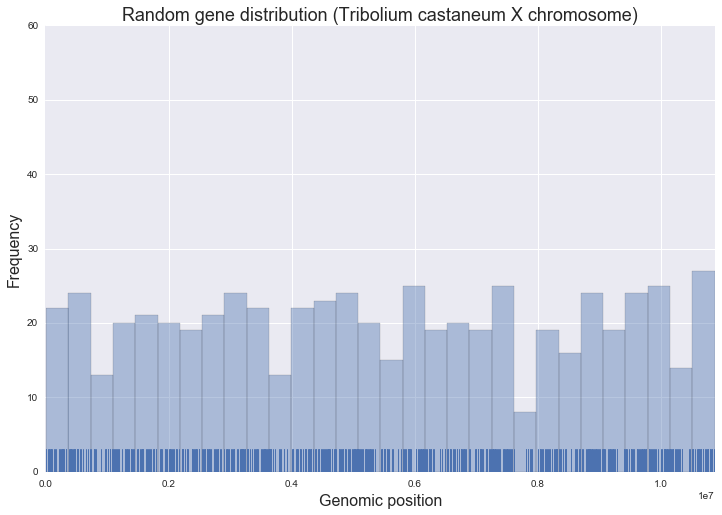

In [11]:
numpy.random.seed(3333)
tc_randintervals, collisions = place_intervals(tc_seqreg, tc_intervals)
starts = [x.start for x in tc_randintervals]
plot_hist_rug(starts, title='Random gene distribution (Tribolium castaneum X chromosome)',
              xlim=(tc_seqreg[1], tc_seqreg[2]), ylim=(0, 60))
print 'Collisions: %d' % collisions

Collisions: 0


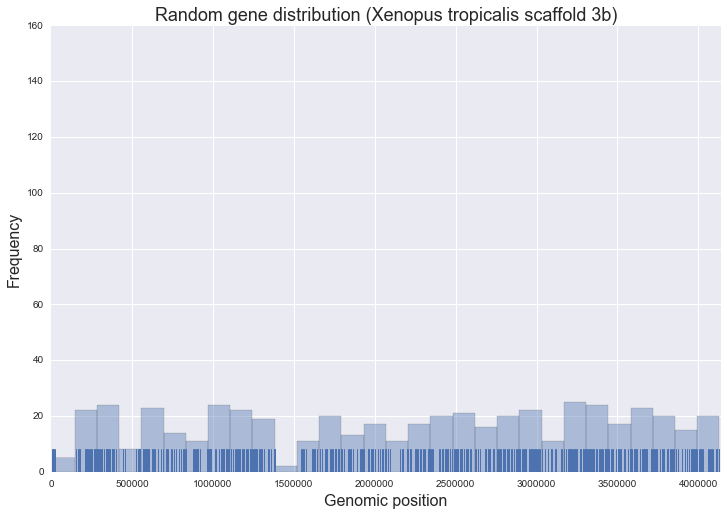

In [12]:
numpy.random.seed(3333)
xt_randintervals, collisions = place_intervals(xt_seqreg, xt_intervals)
starts = [x.start for x in xt_randintervals]
plot_hist_rug(starts, title='Random gene distribution (Xenopus tropicalis scaffold 3b)',
              xlim=(xt_seqreg[1], xt_seqreg[2]), ylim=(0, 160))
print 'Collisions: %d' % collisions